# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [60]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


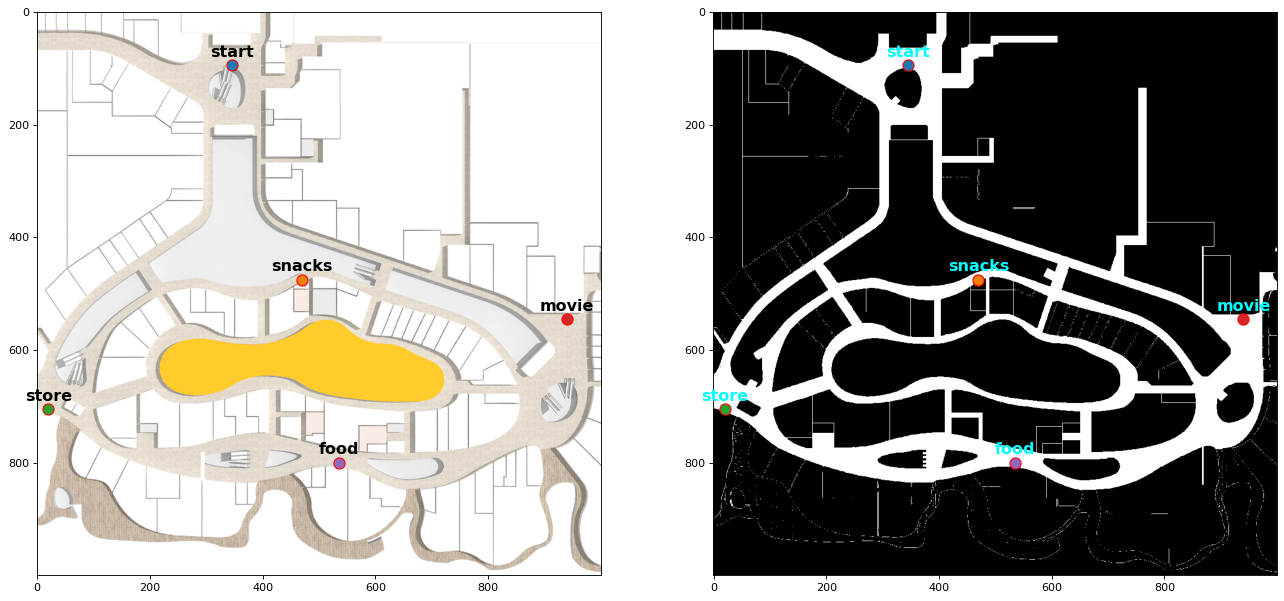

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [61]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

In [62]:
# Importing required libraries for A* implementation
import heapq
import time


In [63]:
grid_map = grid_map_img
start = tuple(locations['start'])
goal = tuple(locations['snacks'])


In [64]:
# Define the heuristic function (Euclidean distance)
def euclidean_heuristic(cell, goal):
    return np.linalg.norm(np.array(cell) - np.array(goal))

# Define manhattan heuristic function
def manhattan_heuristic(cell, goal):
    return np.abs(cell[0] - goal[0]) + np.abs(cell[1] - goal[1])

## Task 1.1 A* implementation

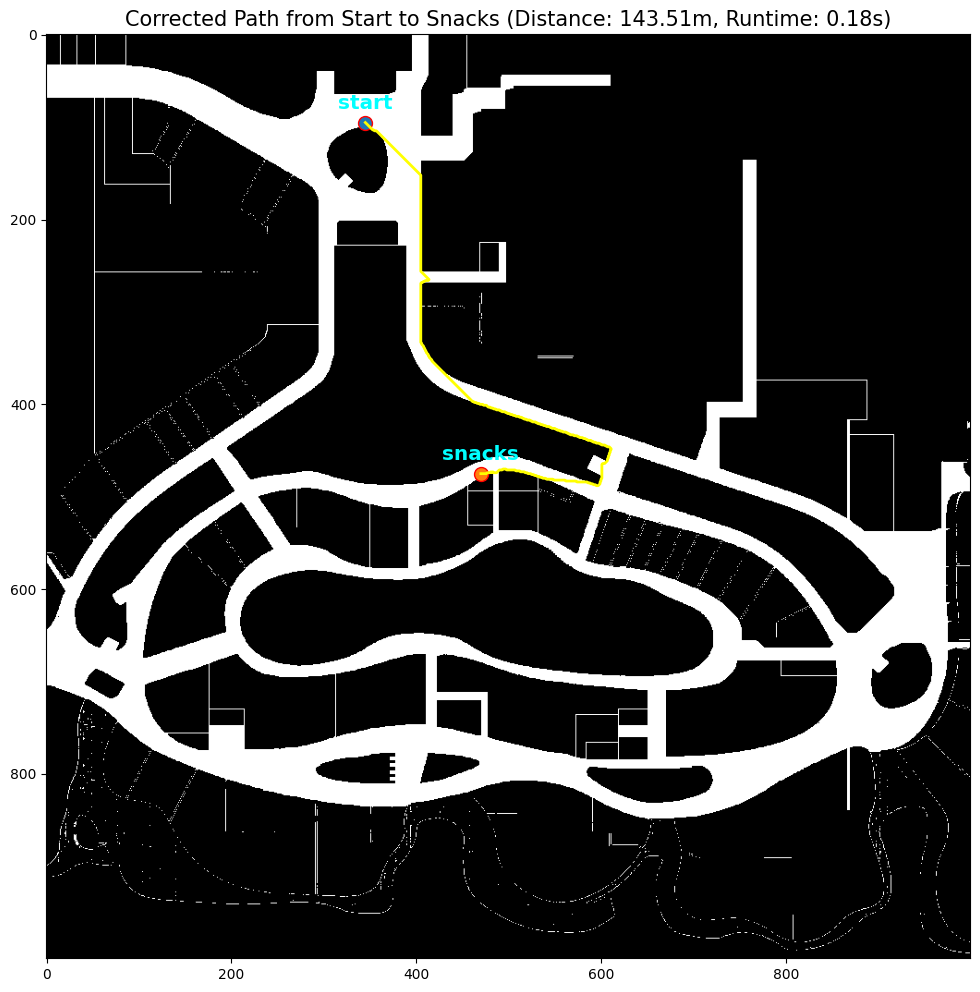

(143.5119999999999, 0.1811985969543457, 5594)

In [66]:
# A* algorithm implementation
def astar(grid_map, start, goal, heuristic):
    start_time = time.time()
    neighbors = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    open_set = []
    heapq.heappush(open_set, (0 + heuristic(start, goal), 0, start, [start]))

    visited = set()
    cost_map = {start: 0}
    visited_cells = []

    while open_set:
        _, current_cost, current_cell, path = heapq.heappop(open_set)
        
        if current_cell in visited:
            continue

        visited.add(current_cell)
        visited_cells.append(current_cell)
        
        if current_cell == goal:
            return path, current_cost, visited_cells, time.time() - start_time

        for dy, dx in neighbors:
            neighbor = (current_cell[0] + dx, current_cell[1] + dy)
            if 0 <= neighbor[0] < grid_map.shape[1] and 0 <= neighbor[1] < grid_map.shape[0]:
                if grid_map[neighbor[1], neighbor[0]] == 0:
                    continue

                step_cost = 0.282 if dx != 0 and dy != 0 else 0.2
                new_cost = current_cost + step_cost

                if neighbor not in cost_map or new_cost < cost_map[neighbor]:
                    cost_map[neighbor] = new_cost
                    priority = new_cost + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (priority, new_cost, neighbor, path + [neighbor]))

    return None, np.inf, visited_cells, time.time() - start_time

# Run A* from "start" to "snacks"
path, distance, visited_cells, runtime = astar(grid_map_img, start, goal, euclidean_heuristic)

# Plot result
plt.figure(figsize=(12, 12))
plt.imshow(grid_map_img, cmap='gray')
plot_locations({'start': locations['start'], 'snacks': locations['snacks']}, color='cyan')

if path:
    path_array = np.array(path)
    plt.plot(path_array[:, 0], path_array[:, 1], color='yellow', linewidth=2)
    plt.title(f'Corrected Path from Start to Snacks (Distance: {distance:.2f}m, Runtime: {runtime:.2f}s)', fontsize=15)
else:
    plt.title('No Path Found!', fontsize=15)

plt.show()

distance, runtime, len(visited_cells)


In [68]:
# Compute the shortest distances between all pairs of locations and summarize in a matrix
location_keys = list(locations.keys())
num_locations = len(location_keys)
distance_matrix = np.zeros((num_locations, num_locations))

# Calculate the shortest path distances between all pairs
for i in range(num_locations):
    for j in range(num_locations):
        if i != j:
            start = tuple(locations[location_keys[i]])
            goal = tuple(locations[location_keys[j]])
            path, distance, _, _ = astar(grid_map_img, start, goal, euclidean_heuristic)
            distance_matrix[i, j] = distance
        else:
            distance_matrix[i, j] = 0.0


In [69]:
import pandas as pd
# Display the distance matrix clearly using pandas DataFrame
distance_df = pd.DataFrame(distance_matrix, columns=location_keys, index=location_keys)

print("Distance Matrix between Locations:")
display(distance_df)

Distance Matrix between Locations:


,start,snacks,store,movie,food
start,0.000,143.512,162.724,181.816,236.036
snacks,152.988,0.000,121.620,130.362,135.410
store,166.502,116.492,0.000,253.832,114.968
movie,226.170,109.198,239.936,0.000,203.626
food,235.808,136.046,122.190,116.420,0.000


## Task 1.2 A* with Manhattan distance heuristic VS. Greedy Best First Search

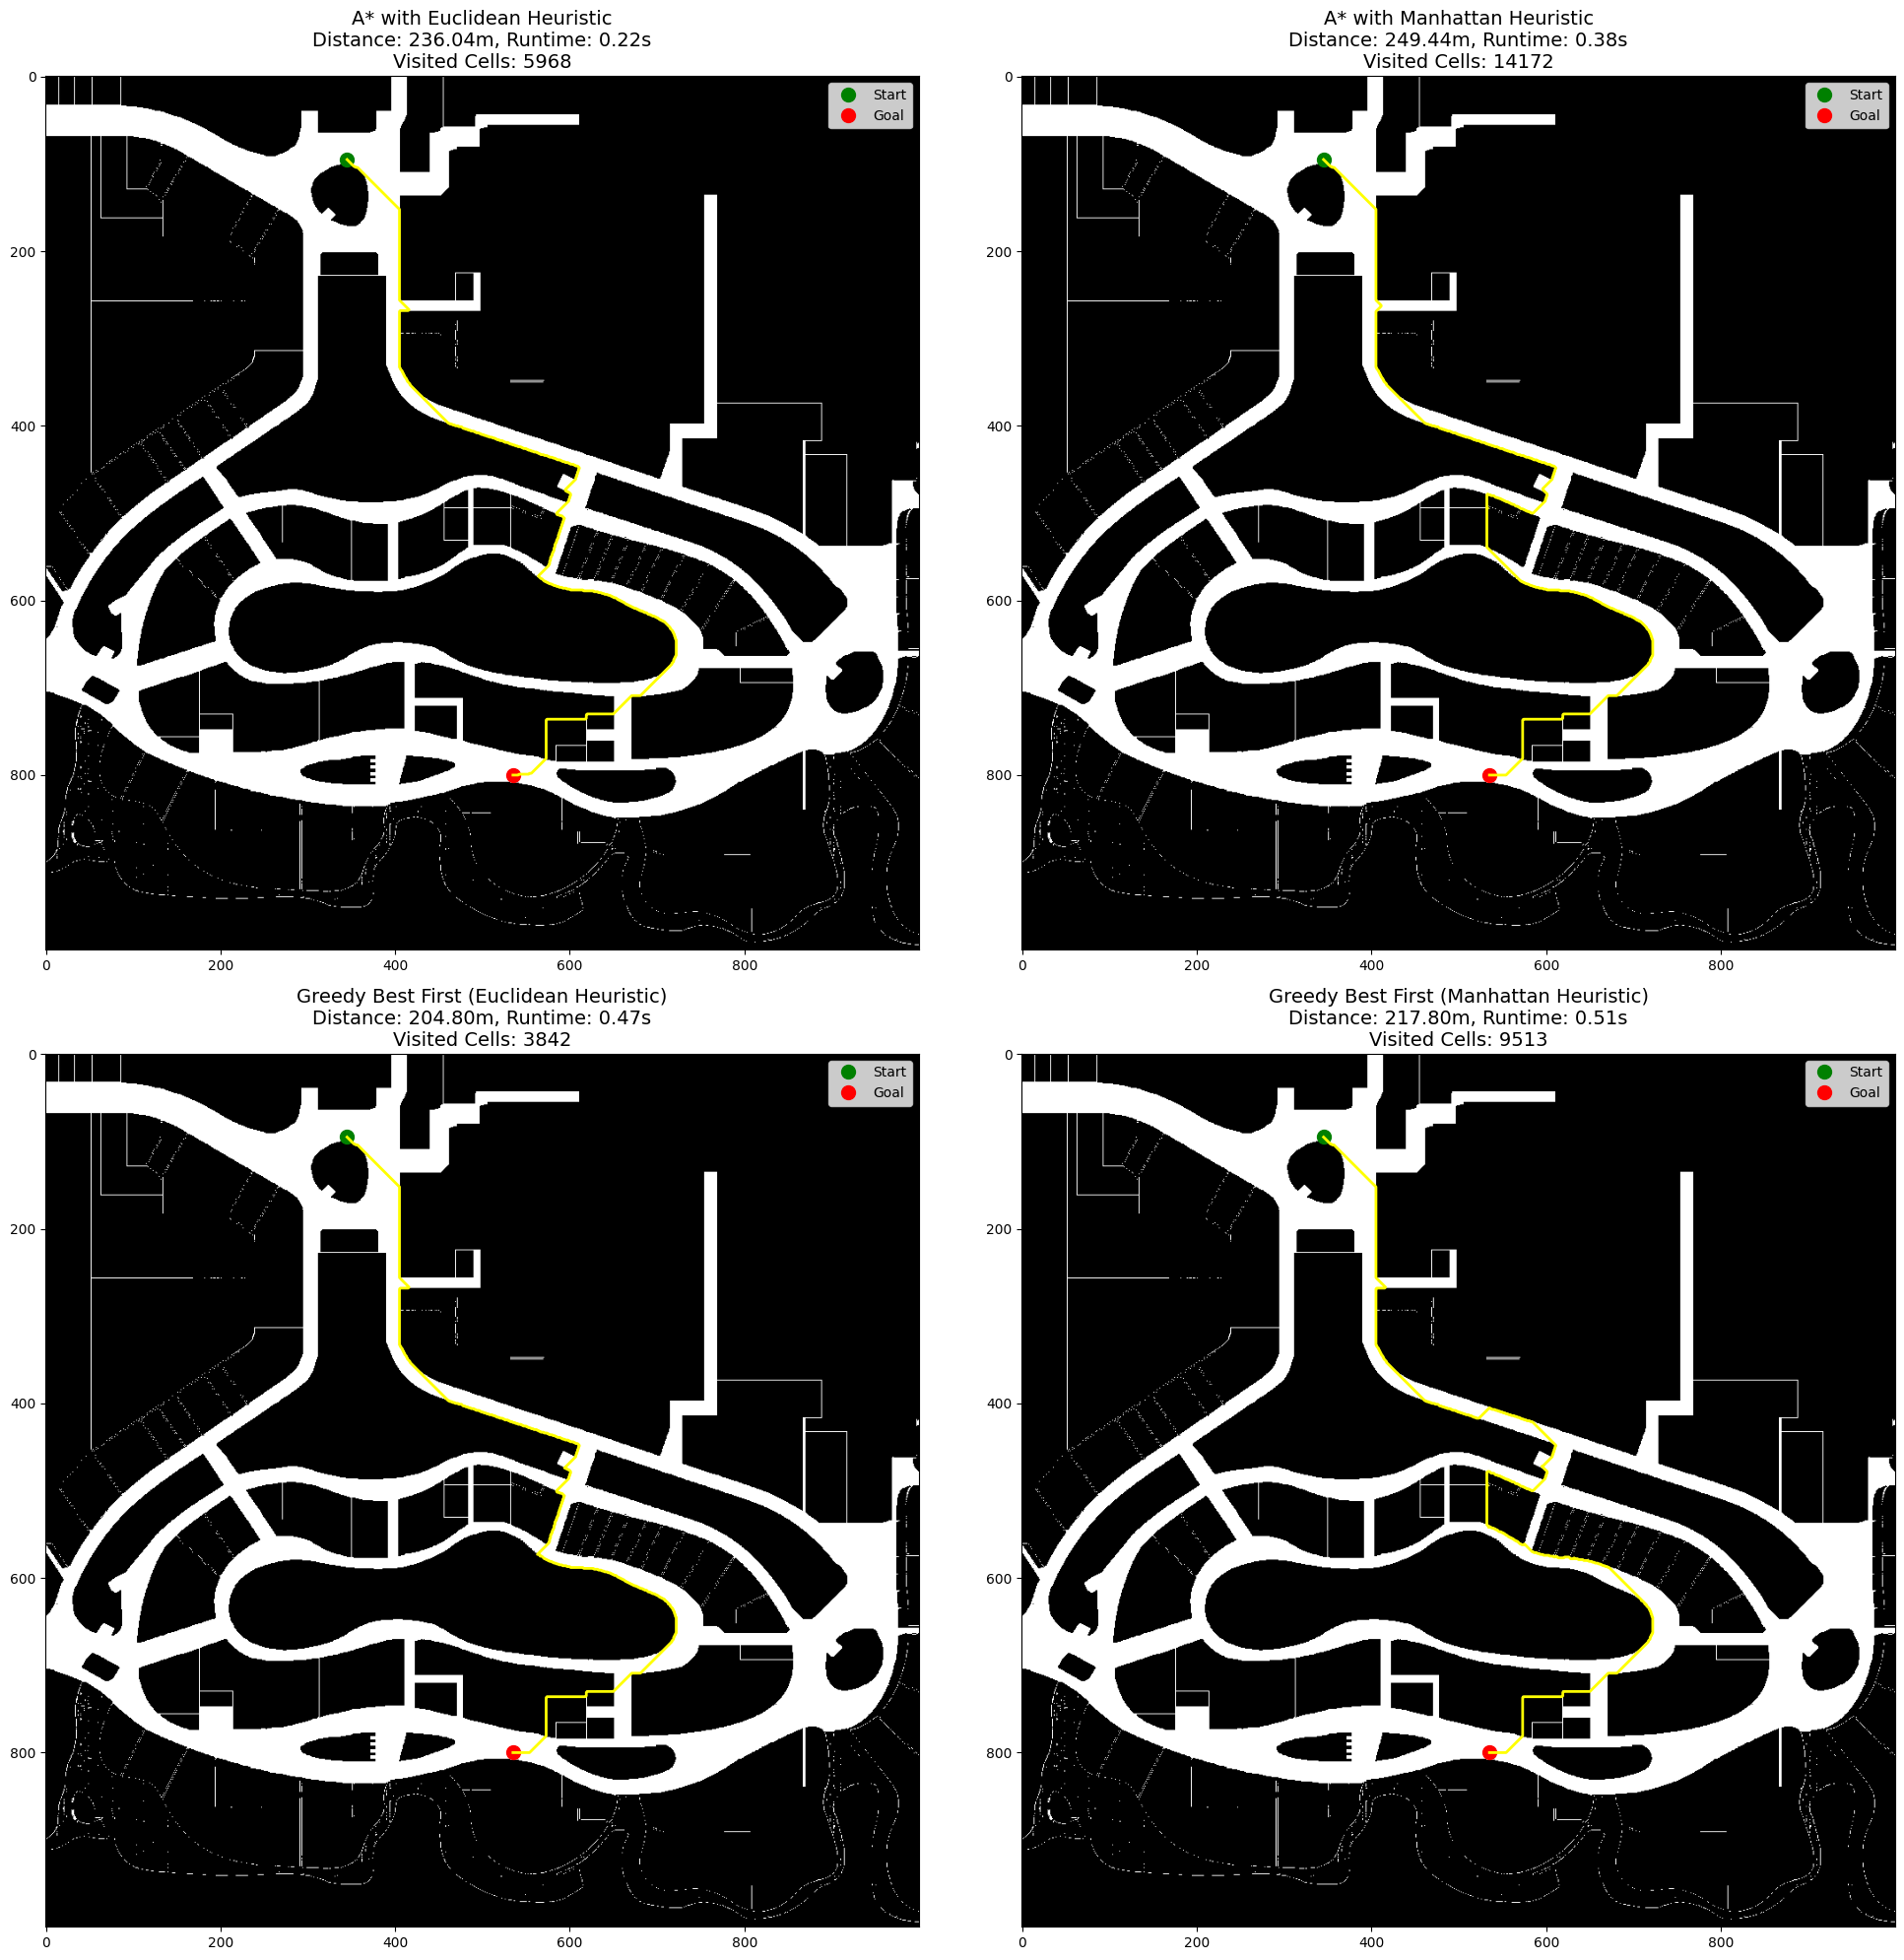

,Algorithm,Distance (m),Runtime (s),Visited Cells
0,A* (Euclidean),236.036,0.222691,5968
1,A* (Manhattan),249.440,0.377099,14172
2,Greedy Best First (Euclidean),204.800,0.473876,3842
3,Greedy Best First (Manhattan),217.800,0.513129,9513


In [71]:
# Greedy Best First Search implementation
def greedy_best_first_search(grid_map, start, goal, heuristic):
    start_time = time.time()
    neighbors = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    open_set = []
    heapq.heappush(open_set, (heuristic(start, goal), start, [start]))

    visited = set()
    visited_cells = []

    while open_set:
        _, current_cell, path = heapq.heappop(open_set)

        if current_cell in visited:
            continue

        visited.add(current_cell)
        visited_cells.append(current_cell)

        if current_cell == goal:
            return path, visited_cells, time.time() - start_time

        for dy, dx in neighbors:
            neighbor = (current_cell[0] + dx, current_cell[1] + dy)
            if 0 <= neighbor[0] < grid_map.shape[1] and 0 <= neighbor[1] < grid_map.shape[0]:
                if grid_map[neighbor[1], neighbor[0]] == 0:
                    continue
                priority = heuristic(neighbor, goal)
                heapq.heappush(open_set, (priority, neighbor, path + [neighbor]))
    return None, visited_cells, time.time() - start_time
# Path from "start" to "food"
start = tuple(locations['start'])
goal = tuple(locations['food'])

# Variant 0: A* with Euclidean heuristic
path_euclidean, dist_euclidean, visited_euclidean, time_euclidean = astar(grid_map_img, start, goal, euclidean_heuristic)

# Variant 1: A* with Manhattan heuristic
path_manhattan, dist_manhattan, visited_manhattan, time_manhattan = astar(grid_map_img, start, goal, manhattan_heuristic)

# Variant 2: Greedy Best First Search (Euclidean heuristic)
path_greedy, visited_greedy, time_greedy = greedy_best_first_search(grid_map_img, start, goal, euclidean_heuristic)
dist_greedy = len(path_greedy) * 0.2 if path_greedy else np.inf

# Variant 3: Greedy Best First Search (Manhattan heuristic)
path_greedy_manhattan, visited_greedy_manhattan, time_greedy_manhattan = greedy_best_first_search(grid_map_img, start, goal, manhattan_heuristic)
dist_greedy_manhattan = len(path_greedy_manhattan) * 0.2 if path_greedy_manhattan else np.inf

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for ax, path, visited, title, dist, runtime in zip(
    axes.flat, 
    [path_euclidean, path_manhattan, path_greedy, path_greedy_manhattan],
    [visited_euclidean, visited_manhattan, visited_greedy, visited_greedy_manhattan],
    ["A* with Euclidean Heuristic", "A* with Manhattan Heuristic", "Greedy Best First (Euclidean Heuristic)", "Greedy Best First (Manhattan Heuristic)"],
    [dist_euclidean, dist_manhattan, dist_greedy, dist_greedy_manhattan],
    [time_euclidean, time_manhattan, time_greedy, time_greedy_manhattan]
): 
    ax.imshow(grid_map_img, cmap='gray')
    ax.plot(start[0], start[1], 'go', markersize=10, label='Start')
    ax.plot(goal[0], goal[1], 'ro', markersize=10, label='Goal')
    if path:
        path_array = np.array(path)
        ax.plot(path_array[:, 0], path_array[:, 1], color='yellow', linewidth=2)
        ax.set_title(f'{title}\nDistance: {dist:.2f}m, Runtime: {runtime:.2f}s\nVisited Cells: {len(visited)}', fontsize=14)
    else:
        ax.set_title(f'{title}\nNo Path Found', fontsize=14)
    ax.legend()

plt.tight_layout()
plt.show()

# Display comparison results
comparison_results = pd.DataFrame({
    "Algorithm": ["A* (Euclidean)", "A* (Manhattan)", "Greedy Best First (Euclidean)", "Greedy Best First (Manhattan)"],
    "Distance (m)": [dist_euclidean, dist_manhattan, dist_greedy, dist_greedy_manhattan],
    "Runtime (s)": [time_euclidean, time_manhattan, time_greedy, time_greedy_manhattan],
    "Visited Cells": [len(visited_euclidean), len(visited_manhattan), len(visited_greedy), len(visited_greedy_manhattan)]
})

comparison_results


## Task 2

In [72]:
import itertools

# Method 1: Exhaustive Search (Brute Force)
def exhaustive_search(distance_matrix, locations):
    location_keys = list(locations.keys())
    location_indices = list(range(1, len(location_keys)))  # Exclude start location (index 0)
    shortest_distance = np.inf
    optimal_route = []

    for perm in itertools.permutations(location_indices):
        route_distance = distance_matrix[0, perm[0]]  # distance from start to first location
        for i in range(len(perm) - 1):
            route_distance += distance_matrix[perm[i], perm[i + 1]]
        route_distance += distance_matrix[perm[-1], 0]  # return to start

        if route_distance < shortest_distance:
            shortest_distance = route_distance
            optimal_route = perm

    optimal_route_keys = ['start'] + [location_keys[i] for i in optimal_route] + ['start']
    return optimal_route_keys, shortest_distance

# Run exhaustive search method
optimal_route_brute, distance_brute = exhaustive_search(distance_matrix, locations)
optimal_route_brute, distance_brute


(['start', 'store', 'food', 'movie', 'snacks', 'start'], 656.2980000000007)

In [ ]:
# Method 2: Held-Karp Algorithm (Dynamic Programming for TSP)
def held_karp(distance_matrix):
    n = len(distance_matrix)
    C = {}

    # Initial state cost
    for k in range(1, n):
        C[(frozenset([0, k]), k)] = (distance_matrix[0][k], [0, k])

    # Iterate over subset sizes
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            subset_frozen = frozenset([0] + list(subset))
            for k in subset:
                prev_subset = subset_frozen - frozenset([k])
                min_cost, min_path = min(
                    (C[(prev_subset, m)][0] + distance_matrix[m][k], C[(prev_subset, m)][1] + [k])
                    for m in subset if m != k
                )
                C[(subset_frozen, k)] = (min_cost, min_path)

    # Close the loop back to the start
    full_set = frozenset(range(n))
    min_cost, min_path = min(
        (C[(full_set, k)][0] + distance_matrix[k][0], C[(full_set, k)][1])
        for k in range(1, n)
    )

    optimal_route = min_path + [0]
    return optimal_route, min_cost

# Run Held-Karp method
optimal_route_indices_dp, distance_dp = held_karp(distance_matrix)
location_keys = list(locations.keys())
optimal_route_dp = [location_keys[i] for i in optimal_route_indices_dp]

optimal_route_dp, distance_dp


(['start', 'store', 'food', 'movie', 'snacks', 'start'], 656.2980000000007)

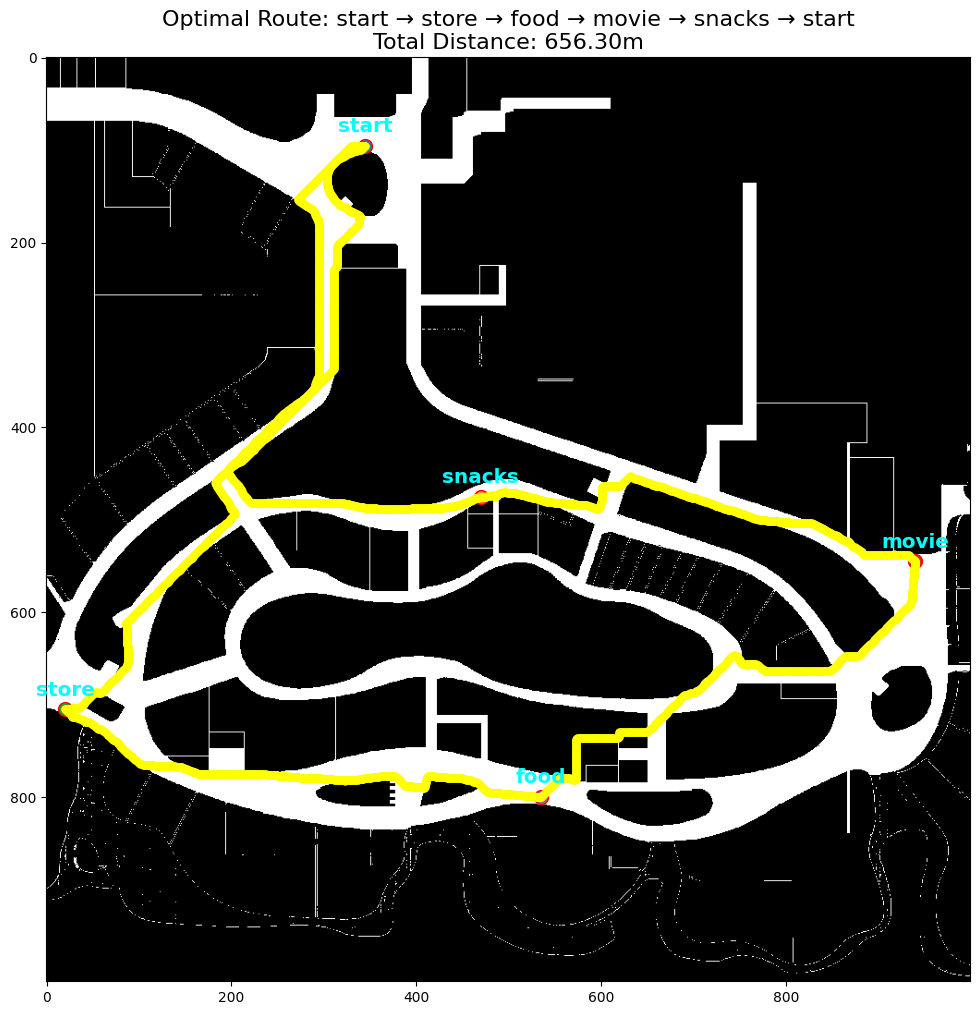

In [74]:
# Visualizing the optimal route clearly on the map
plt.figure(figsize=(12, 12))
plt.imshow(grid_map_img, cmap='gray')

# Mark all locations
plot_locations(locations, color='cyan')

# Plot optimal route
optimal_path_full = []
total_distance = 0
for i in range(len(optimal_route_dp) - 1):
    start = tuple(locations[optimal_route_dp[i]])
    goal = tuple(locations[optimal_route_dp[i + 1]])
    path_segment, _, _, _ = astar(grid_map_img, start, goal, euclidean_heuristic)
    if path_segment:
        optimal_path_full.extend(path_segment)
        total_distance += euclidean_heuristic(start, goal)

optimal_path_full = np.array(optimal_path_full)
plt.plot(optimal_path_full[:, 0], optimal_path_full[:, 1], color='yellow', linewidth=2, marker='o', markersize=5)
plt.title(f'Optimal Route: {" → ".join(optimal_route_dp)}\nTotal Distance: {distance_dp:.2f}m', fontsize=16)
plt.show()
